# Bayesian AB Testing Part I - Conversions

### Series Structure
In a [previous blog post](https://towardsdatascience.com/bayesian-experimentation-methods-for-products-636514951e43), I discussed the advantages of using Bayesian AB testing methods rather than frequentist ones. In this series of blog posts, I will be taking a deeper dive into the calculations involved and how to implement them in real world scenarios. The structure of the series will be as follows:

1. Modelling and analysis of conversion based test metrics (rate metrics)
2. Modelling and analysis of revenue based test metrics (continuous metrics)
3. Calculating test duration
4. Choosing an appropriate prior
5. Running tests with multiple variants

So without further ado, let's jump into how to model, use and analyse conversion based test metrics in bayesian product experiments.

### Experiment Context
Following on from the example used in the [previous post](https://towardsdatascience.com/bayesian-experimentation-methods-for-products-636514951e43), let's assume we've recently changed the messaging on an upsell screen and want to AB test it before releasing to our wider user base. We hypothesise that the changes we've made will result in a significantly better conversion rate.

Similar to frequentist methods, we can model each conversion on the upsell screen, $X$, as Bernoulli random variable with conversion probability $\lambda$:

$X \sim Ber(\lambda) \\ p(X=1) = \lambda \\ p(X=0) = 1 - \lambda$

While under the frequentist methodology we'd assume that $\lambda$ is a constant, under the bayesian methodology we model it as a random variable with its own probability distribution. Our first step is to choose an appropriate approximation for this distribution using past data. We call this our prior distribution of $\lambda$. 

We then set our loss threshold, which is the largest expected loss we're willing to accept if we were to make a mistake. As with any statistical modelling, bayesian experimentation methods are built on approximations of real world data. As such there is always a chance that we draw the wrong conclusions from the test. This loss threshold allows us to say that even if we did draw the wrong conclusions, we can be confident that the conversion rate wouldn't drop more than this threshold.

Finally, we draw samples in the form of a randomised experiment and use these to update the distribution, and thus our beliefs, about $\lambda$ under the control and treatment versions of the upsell screen. We can use these posterior distributions to calculate the probabilities and expected loss that we're interested in.

So our first step is to choose a prior distribution of $\lambda$. To do this we can look at the data we've recently (last few weeks) gathered about this conversion. I've generated a sample prior data set which we can use for this exercise.

In [ ]:
import pandas as pd
import numpy as np
import uuid

SAMPLE_SIZE = 5268
CONVERSION_PROBABILITY = 0.326


if __name__ == "__main__":
    user_ids = [uuid.uuid4().hex for i in range(SAMPLE_SIZE)]
    conversion_flips = np.random.uniform(0,1,SAMPLE_SIZE)
    converted = [i <= CONVERSION_PROBABILITY for i in conversion_flips]
    
    data = pd.DataFrame()
    data['userId'] = user_ids
    data['converted'] = converted 

    data.to_csv('prior_data.csv', index=False)

In [7]:
conversion_flips
# converted

array([0.71124975, 0.55669102, 0.94499412, ..., 0.71930281, 0.69978783,
       0.67590079])

In [3]:
import pandas as pd

prior_data = pd.read_csv('prior_data.csv')
    
print(prior_data.head())
print(prior_data.shape)

                             userId  converted
0  3b9a48d5f5b841c8a2ba794bc7cf9b37      False
1  52707fdf04bb4459b04c58c7dfa0a904      False
2  d4090815a19741b2a464a0c84f69ee86      False
3  695af966d1f64557a74a79ca81ff83d0      False
4  ab3b5c1b0df1413e84c7b885099ba8c0      False
(5268, 2)


Since this data set is artificially generated, it's already in the ideal format for this exercise. In the real world, it's likely that we'd need to perform some ETL operations in order to get the data in this format. However this is outside the scope of this post.

We see that we have a sample size of 5268 users, and for each user we can see whether they converted on this screen or not. We can go ahead and work out the prior conversion rate.

In [4]:
conversion_rate = prior_data['converted'].sum()/prior_data.shape[0]

print(f'Prior Conversion Rate is {round(conversion_rate, 3)}')

Prior Conversion Rate is 0.321


### Choosing a Prior Distribution
We see that our prior data gives us a conversion rate of ~30%. We now use this to choose a prior distribution for $\lambda$. Choosing a prior is an important aspect of bayesian experimentation methods, and deserves a post on its own. I will be diving into it in more depth in part 4 of this series. However, for the purposes of this post, I will be using a rough method of choosing a prior.

We're going to use the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) to model our conversion rate since it's a flexible distribution over $[0,1]$ and is also a good [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior). It will make our calculations easier when we work out posteriors with experiment data.

When choosing a prior distribution for our conversion, it's best practice to choose a weaker prior than the prior data suggests. Once again I will explore this in more depth in part 4 of this series, but essentially, choosing too strong a prior could result in our posterior distributions being wrong and could therefore lead to wrong calculations and conclusions.

With that in mind, let's look at potential priors of varying strength.

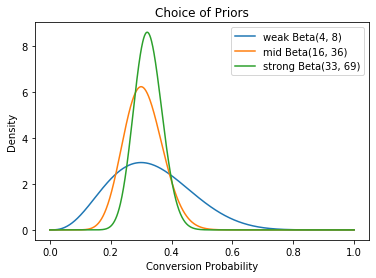

In [16]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

x = np.linspace(0,1,1000)

beta_weak = beta(round(conversion_rate, 1)*10 + 1, 10 + 1 - round(conversion_rate, 1)*10)
beta_mid = beta(round(conversion_rate, 1)*50 + 1, 50 + 1 - round(conversion_rate, 1)*50)
beta_strong = beta(round(conversion_rate, 2)*100 + 1, 100 + 1 - round(conversion_rate, 2)*100)

ax.plot(x, beta_weak.pdf(x), label=f'weak Beta({int(round(conversion_rate, 1)*10) + 1}, {10 + 1 - int(round(conversion_rate, 1)*10)})')
ax.plot(x, beta_mid.pdf(x), label=f'mid Beta({int(round(conversion_rate, 1)*50) + 1}, {50 + 1 - int(round(conversion_rate, 1)*50)})')
ax.plot(x, beta_strong.pdf(x), label=f'strong Beta({int(round(conversion_rate, 2)*100) + 1}, {100 + 1 - int(round(conversion_rate, 2)*100)})')
ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Choice of Priors')
ax.legend()


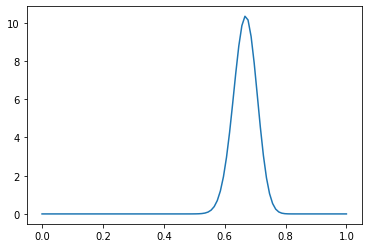

In [18]:
# fig, ax = plt.subplots(1, 1)
beta_test = beta(100,50)
x = np.linspace(0,1,100)
plt.plot(x, beta_test.pdf(x))
plt.show()

Here we can see three prior distributions which have a mean conversion rate of ~30%, similar to our prior data, and are all much weaker than the true distribution of the prior data.

Let's choose a prior that is in between the weakest and mid priors in the diagram $Beta(7, 15)$

$p(\lambda) = \frac{\lambda^6(1-\lambda)^{14}}{B(7,15)} $ 

where $B(a,b)$ is the [beta function](https://en.wikipedia.org/wiki/Beta_function) defined as 

$B(a,b) = \int_0^1 x^{a-1}(1-x)^{b-1}dx$

and has the property

$B(a,b) = \frac{(a-1)!(b-1)!}{(a+b-1)!}$

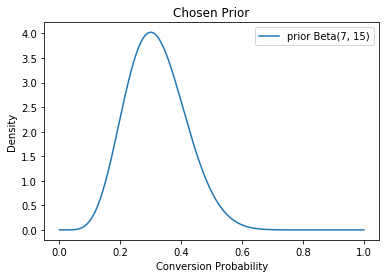

In [32]:
prior_alpha = round(conversion_rate, 1)*20 + 1
prior_beta = 20 + 1 - round(conversion_rate, 1)*20

prior = beta(prior_alpha, prior_beta)

fig, ax = plt.subplots(1, 1)

x = np.linspace(0,1,1000)

ax.plot(x, prior.pdf(x), label=f'prior Beta({int(round(conversion_rate, 1)*20) + 1}, {20 + 1 - int(round(conversion_rate, 1)*20)})')
ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Chosen Prior')
ax.legend()

### Setting a loss threshold
Now that we've chosen our prior, we need to choose our $\epsilon$ which is the highest expected loss we're willing to accept in the case where we mistakenly choose the wrong variant. Let us assume that this is an important conversion for us so we want to be pretty conservative with this $\epsilon$. We aren't willing to accept a relative expected loss of more than 0.5%. So we set $\epsilon = 0.005*0.3 = 0.0015$.

We have a prior and a threshold for our expected loss, so we can start running our experiment and gathering data from it.

### Experiment Results
Let's assume that we've left our experiment running for a couple of weeks and want to check whether we can draw any conclusions from it. In order to do this we need to use our experiment data to calculate our posterior distributions, which we can then use to calculate the probability of each variant being better, and also the expected loss of wrongly choosing each variant.

For the purposes of this exercise, I've generated a sample experiment data set. Let's start off by exploring it and aggregating it to find out the conversion rates of each variant.

In [21]:
import pandas as pd
import numpy as np
import uuid

CONTROL_SIZE = 2743
CONTROL_CONVERSION_PROBABILITY = 0.326

TREATMENT_SIZE = 2358
TREATMENT_CONVERSION_PROBABILITY = 0.345


if __name__ == "__main__":
    control_user_ids = [uuid.uuid4().hex for i in range(CONTROL_SIZE)]
    control_conversion_flips = np.random.uniform(0,1,CONTROL_SIZE)
    control_converted = [i <= CONTROL_CONVERSION_PROBABILITY for i in control_conversion_flips]
    
    control = pd.DataFrame()
    control['userId'] = control_user_ids
    control['group'] = 'control'
    control['converted'] = control_converted

    treatment_user_ids = [uuid.uuid4().hex for i in range(TREATMENT_SIZE)]
    treatment_conversion_flips = np.random.uniform(0,1,TREATMENT_SIZE)
    treatment_converted = [i <= TREATMENT_CONVERSION_PROBABILITY for i in treatment_conversion_flips]
    
    treatment = pd.DataFrame()
    treatment['userId'] = treatment_user_ids
    treatment['group'] = 'treatment'
    treatment['converted'] = treatment_converted

    results = pd.concat([control, treatment])
    results = results.sample(frac=1)
    results.to_csv('experiment_data.csv', index=False)

In [25]:
experiment_data = pd.read_csv('experiment_data.csv')

print(experiment_data.head())
print(experiment_data.shape)

                             userId      group  converted
0  cdcfc7b2a3594601a6b14847006394a7    control      False
1  4cc143c66b6345578e736220b66dbe70  treatment      False
2  7af46377eea74840bba8936eddc6717e    control      False
3  683f7726e83042f79ea9889dcc8df941    control      False
4  9508f7c1f9d2479687aa9a6c5edbfac4    control      False
(5101, 3)


We see that the data set is similar to the prior data set with an extra column for specifying which the group the user was allocated to and therefore which variant they saw. Once again it's worth noting that since this data set is artificially generated, it's already in the ideal format for this exercise wihtout the need for additional ETL operations.

We can now go ahead and aggregate the data.

In [30]:
result = experiment_data.groupby('group').agg({'userId':'nunique','converted':sum})
result['conversionRate'] = result['converted']/result['userId']

In [31]:
result

,userId,converted,conversionRate
group,,,
control,2743,881.0,0.321181
treatment,2358,821.0,0.348176


In [29]:
results = experiment_data.groupby('group').agg({'userId': pd.Series.nunique, 'converted': sum})
results.rename({'userId': 'sampleSize'}, axis=1, inplace=True)
results['conversionRate'] = results['converted']/results['sampleSize']

print(results)

           sampleSize  converted  conversionRate
group                                           
control          2743      881.0        0.321181
treatment        2358      821.0        0.348176


We can tell by inspection that treatment had a better conversion rate, but we need to perform further calculations in order to update our beliefs about the respective conversion probabilities $\lambda_c$ and $\lambda_t$ of the control and treatment variants.

With our experiment data, we can now calculate our posterior distributions under each variant. But before we do let's explore the maths behind how this is possible from just the information that we have. We're going to use a theorem that states the following:

Suppose the prior

$p(\lambda) = f(\lambda;a,b) = \frac{\lambda^{a-1}(1-\lambda)^{b-1}}{B(a,b)} $

Suppose a variant was displayed to $n$ visitors and $c$ converted, then the posterior distribution of the variant is given by

$p(\lambda|n,c) = f(\lambda;a+c,b+n-c)$

Let's go ahead and prove this. By [bayes theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) we have the following

$p(\lambda|n,c) = \frac{p(n,c|\lambda)p(\lambda)}{p(n,c)} = \frac{p(n,c|\lambda)p(\lambda)}{\int_0^1p(n,c|\lambda)p(\lambda)d\lambda}$  (1)

Since we modelled each conversion as a Bernoulli RV with probability $\lambda$, given $\lambda$ we can model the result of showing a variant to $n$ visitors as a Binomial RV. So we have

$p(n,c|\lambda) = \binom{n}{c}\lambda^{c}(1-\lambda)^{n-c}$

And thus, using the definition of our prior

$p(n,c|\lambda)p(\lambda) = \binom{n}{c}\frac{1}{B(a,b)}\lambda^{a+c-1}(1-\lambda)^{b+n-c-1}$   (2)

Let's now just consider the coefficients

$\binom{n}{c}\frac{1}{B(a,b)} = \frac{n!}{c!(n-c)!}\frac{1}{B(a,b)} = \frac{1}{B(c+1,n-c+1)}\frac{1}{B(a,b)}$   (3)

Using the definition of the beta function we can say

$B(c+1, n-c+1)*B(a,b) = \int_0^1 x^{c}(1-x)^{n-c}dx*\int_0^1 x^{a-1}(1-x)^{b-1}dx \\ B(c+1, n-c+1)*B(a,b) = \int_0^1 x^{a+c-1}(1-x)^{b+n-c-1}dx = B(a+c, b+n-c)$ (4)

Substituting (3) and (4) back into (2)

$p(n,c|\lambda)p(\lambda) = \frac{1}{B(a+c,b+n-c)}\lambda^{a+c-1}(1-\lambda)^{b+n-c-1} = f(\lambda;a+c,b+n-c)$   (5)

Substituting (5) back into (1)

$p(\lambda|n,c) = \frac{f(\lambda;a+c,b+n-c)}{\int_0^1f(\lambda;a+c,b+n-c)d\lambda}$

Since $f(\lambda;a+c,b+n-c)$ is a distrubtion over $[0,1]$ the denominator is $1$ and we have the result we were after.

Now that we've sufficiently convinced ourselves of the maths, we can calculate our posterior distributions.

In [35]:
result.loc['control','converted']

881.0

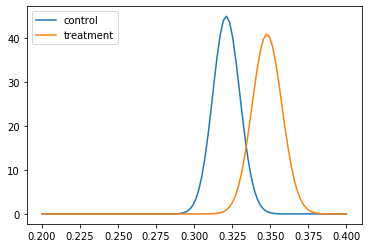

In [46]:
control = beta(prior_alpha+result.loc['control','converted'],prior_beta + result.loc['control','userId'] - result.loc['control', 'converted'])
treatment = beta(prior_alpha+result.loc['treatment','converted'],prior_beta + result.loc['treatment','userId'] - result.loc['treatment', 'converted'])
x = np.linspace(0.2,0.4,100)
plt.plot(x,control.pdf(x),label = 'control')
plt.plot(x,treatment.pdf(x),label = 'treatment')
plt.legend()
plt.show()

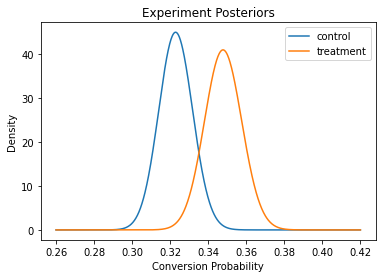

In [17]:
control = beta(prior_alpha + results.loc['control', 'converted'], prior_beta + results.loc['control', 'sampleSize'] - results.loc['control', 'converted'])
treatment = beta(prior_alpha + results.loc['treatment', 'converted'], prior_beta + results.loc['treatment', 'sampleSize'] - results.loc['treatment', 'converted'])


fig, ax = plt.subplots()

x = np.linspace(0.26,0.42,1000)

ax.plot(x, control.pdf(x), label='control')
ax.plot(x, treatment.pdf(x), label='treatment')
ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Experiment Posteriors')
ax.legend()

Now that we've got our posterior distributions, we can go ahead and calculate the joint posterior. Since randomised experiments are built on the idea of random assignment of a user to a variant, we can assume that these two distributions are independent. Note that this isn't always the case. For example, there might be some cases where network effects might be in play and we'd need to take that into consideration. This assumption is also dependent on the procedure of random assignment working properly.

Let us assume that our method of random assignment has worked properly and that there are no network effects. Under this assumption we can say the following:

$ p(\lambda_c, \lambda_t|data) = p(\lambda_c|data)*p(\lambda_t|data)$

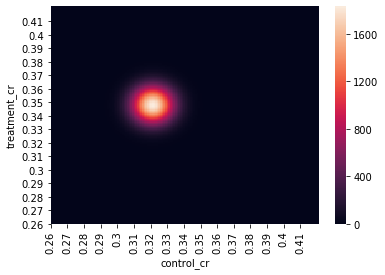

In [47]:
import seaborn as sns

joint_dist_for_plot = []
for i in np.linspace(0.26,0.42,161):
    for j in np.linspace(0.26,0.42,161):
        joint_dist_for_plot.append([i, j, control.pdf(i)*treatment.pdf(j)])

joint_dist_for_plot = pd.DataFrame(joint_dist_for_plot)
joint_dist_for_plot.rename({0: 'control_cr', 1: 'treatment_cr', 2: 'joint_density'}, axis=1, inplace=True)
tick_locations = range(0, 160, 10)
tick_labels = [round(0.26 + i*0.01, 2) for i in range(16)]
heatmap_df = pd.pivot_table(joint_dist_for_plot, values='joint_density', index='treatment_cr', columns='control_cr')

ax = sns.heatmap(heatmap_df)
ax.set_xticks(tick_locations)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_locations)
ax.set_yticklabels(tick_labels)
ax.invert_yaxis()

The blue line in this graph is the line that represents $\lambda_c = \lambda_t$. Since the joint posterior is above this line, we can use this as a visual indication that the treatment is in fact better. If the joint posterior was below the line then we could be pretty sure that control was better. If any part of the joint posterior was on the line then there would be more uncertainty on which variant was better.

In order to quantify this, we need to calculate $p(\lambda_t \geq \lambda_c)$ and $E[L](t)$, the expected loss of wrongly choosing treatment.


In [19]:
import decimal
decimal.getcontext().prec = 4

control_simulation = np.random.beta(prior_alpha + results.loc['control', 'converted'], prior_beta + results.loc['control', 'sampleSize'] - results.loc['control', 'converted'], size=10000)
treatment_simulation = np.random.beta(prior_alpha + results.loc['treatment', 'converted'], prior_beta + results.loc['treatment', 'sampleSize'] - results.loc['treatment', 'converted'], size=10000)

treatment_won = [i <= j for i,j in zip(control_simulation, treatment_simulation)]

chance_of_beating_control = np.mean(treatment_won)
print(f'Chance of treatment beating control is {decimal.getcontext().create_decimal(chance_of_beating_control)}')

Chance of treatment beating control is 0.9697


From the simulations we see that $p(\lambda_t \geq \lambda_c) = 0.9718$ so treatment has a 97% chance of being better than control.

Now that we've calculated the probability of treatment being better, we need to calculate $E[L](t)$. The loss function of each variant is given by 

$L(\lambda_c, \lambda_t,t) = max(\lambda_c - \lambda_t, 0) \\ L(\lambda_c, \lambda_t,c) = max(\lambda_t - \lambda_c, 0)$

So the expected loss of each variant is given by

$E[L](t) = \int_0^1\int_0^1L(\lambda_c, \lambda_t, t)p(\lambda_c,\lambda_t|data)d\lambda_td\lambda_c \\ E[L](c) = \int_0^1\int_0^1L(\lambda_c, \lambda_t, c)p(\lambda_c,\lambda_t|data)d\lambda_td\lambda_c$

We use this to calculate the expected loss

In [20]:
decimal.getcontext().prec = 4

loss_control = [max(j - i, 0) for i,j in zip(control_simulation, treatment_simulation)]
loss_treatment = [max(i - j, 0) for i,j in zip(control_simulation, treatment_simulation)]

all_loss_control = [int(i)*j for i,j in zip(treatment_won, loss_control)]
all_loss_treatment = [(1 - int(i))*j for i,j in zip(treatment_won, loss_treatment)]

expected_loss_control = np.mean(all_loss_control)
expected_loss_treatment = np.mean(all_loss_treatment)

print(f'Expected loss of choosing control: {decimal.getcontext().create_decimal(expected_loss_control)}. Expected loss of choosing treatment: {decimal.getcontext().create_decimal(expected_loss_treatment)}')

Expected loss of choosing control: 0.02511. Expected loss of choosing treatment: 0.0001638


From running simulations we see that:

$E[L](t) = 0.0001369 \lt 0.0015 = \epsilon$

Since the expected loss of one of the variants is below the threshold that we set at the start of the test, the test has reached significance. We can conclude with high confidence that the treatment is better, and that the expected cost of mistakenly choosing treatment would not be greater than what we're comfortable with. So we can strongly recommend that the treatment variant of the upsell screen should be rolled out to the rest of our user base.

### References
1. [VWO Whitepaper](https://cdn2.hubspot.net/hubfs/310840/VWO_SmartStats_technical_whitepaper.pdf) by C. Stucchio
2. [Bayesian A/B testing - a practical exploration with simulations](https://towardsdatascience.com/exploring-bayesian-a-b-testing-with-simulations-7500b4fc55bc) by Blake Arnold - I've used the logic from Blake's code for calculating expected loss
3. Also found [The Power of Bayesian A/B Testing](https://medium.com/convoy-tech/the-power-of-bayesian-a-b-testing-f859d2219d5) by Michael Frasco very helpful in understanding the technical aspects of bayesian AB testing methods